# Image segmentation

In [1]:
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import cv2 as cv


In [2]:
# utils

def div(px,py):
    '''
    calcul de la divergence d'un vecteur (px,py)
    px et py de meme taille
    (de sorte que div=-(grad)^*)'''
    
    m,n = px.shape
    M  = np.zeros((n,m))
    Mx = np.copy(M)
    My = np.copy(M)
    Mx[1:m-1,:] = px[1:m-1,:] - px[:m-2,:]
    Mx[0,:] = px[0,:]
    Mx[-1,:] = px[-1,:]
    
    My[:,1:m-1] = py[:,1:m-1] - py[:,:m-2]
    My[:,0] = py[:,0]
    My[:,n] = py[:,n]
    return Mx + My

def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y

def Gradient(I):
    y=[]
    y.append(GradientHor(I))
    y.append(GradientVer(I))
    return np.array(y)

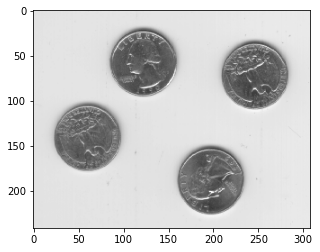

In [3]:

I = cv.imread('eight.tif')
#np.shape(I)
plt.imshow(I)
plt.show()

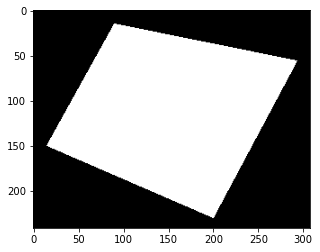

In [4]:
img = cv.imread('eight.tif')
mask = np.zeros(img.shape[:2],dtype = 'uint8')

c = [15, 90, 293, 200]
r = [150, 15, 56, 230]

rc = np.array((c,r)).T

cv.drawContours(mask,[rc],0,255,-1)
cv.drawContours(img,[rc],0,255,2)
mask = cv.cvtColor(mask,cv.COLOR_GRAY2BGR)

res = np.hstack((img,mask))
plt.imshow(mask)


In [5]:
#mask = cv.threshold(I, thresh = 210, maxval = 255., type = cv.THRESH_BINARY_INV)[1]


In [6]:
mask = mask/255.

# Chan-Esedoglu-Nikolova

In [7]:

def ChanEsedogluNikolova(I,u, eta = 0.5, tau = 0.5, mu = 0.5,lamb = 1,c1 = 110, c2 = 227, compute_c = True, thresh = 10e-5, eps = 10e-9):
    niter = 1
    gradu = Gradient(u)
    tmp = u + tau*(Div(gradu/npl.norm(gradu+eps)) - lamb*(I-c1)**2 + lamb*(I-c2)**2)
    unext = np.minimum(np.maximum(tmp,0.),1.)
    energy = []
    while npl.norm(unext[:,:,0] -u[:,:,0],2) > thresh and niter < 1000:
        u = unext
        gradu = Gradient(u)
        if compute_c:
            c1 = np.sum(I*u)/np.sum(u)
            c2 = np.sum(I*(1-u)) / np.sum(1-u)
        tmp = u + tau*(Div(gradu/npl.norm(gradu + eps)) - lamb*(I-c1)**2 + lamb*(I-c2)**2)
        unext = np.minimum(np.maximum(tmp,0.),1.)
        niter += 1
        energy += [compute_energy_smooth(u,I,c1,c2,lamb)]
    
    return unext, niter, energy

def compute_energy_smooth(u, img, c1, c2, lam, eps = 1e-5):
    return np.sum(npl.norm(Gradient(u) + 0.001)) +  lam*np.sum((np.abs(img - c1)**2*u) + np.sum(np.abs(img - c2)**2 *(1-u)))

In [8]:
def plot_results(Org,Im, mask):
    plt.figure(figsize = (20,24))
    plt.subplot(1,3,1)
    plt.imshow(Org)
    plt.title("Original image")
    plt.subplot(1,3,2)
    plt.imshow(Im)
    plt.title("Segmented image")
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title("Initial mask")
    plt.show()

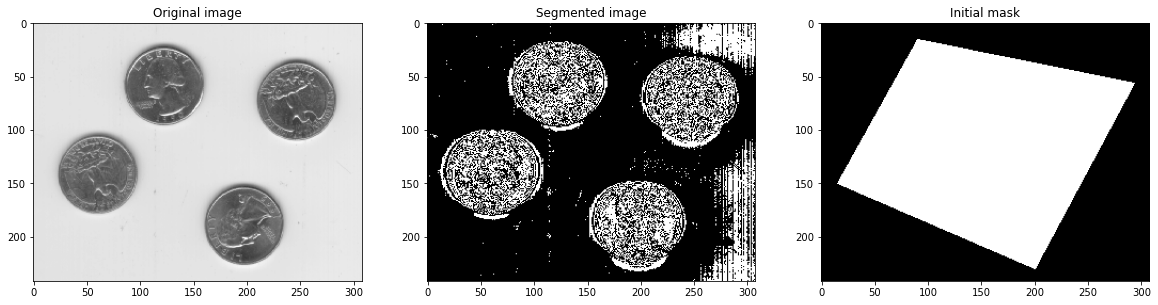

In [9]:
u, niter,energy = ChanEsedogluNikolova(I,mask,compute_c = False, lamb = 0.001)
plot_results(I, u, mask)

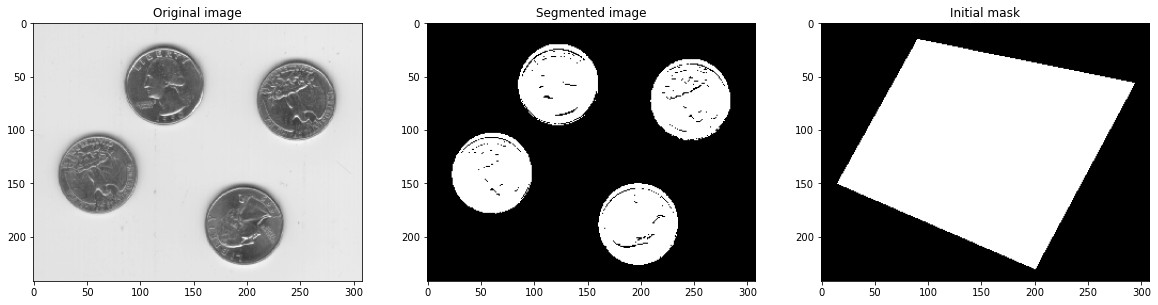

In [10]:
u, niter,energy = ChanEsedogluNikolova(I,mask, lamb = 0.001)
plot_results(I,u,mask)

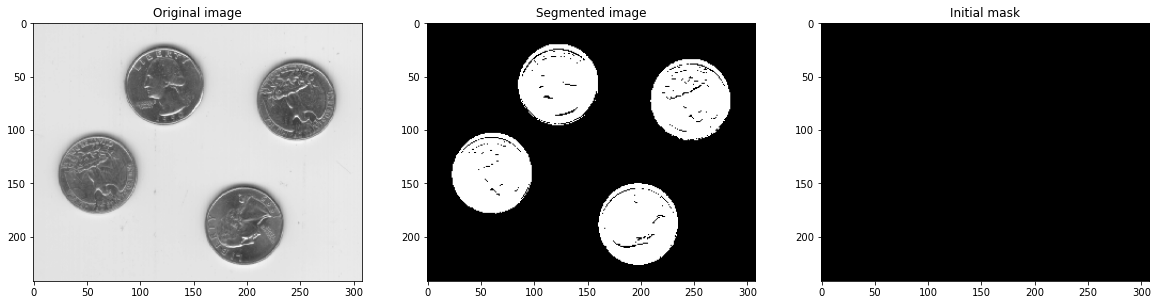

In [11]:
mask2 = np.zeros_like(I)
u, niter,energy = ChanEsedogluNikolova(I,mask2, lamb = 0.001)
plot_results(I,u,mask2)

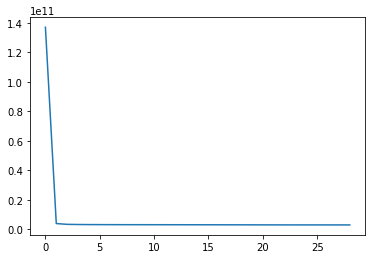

In [12]:
plt.plot(energy)
plt.show()

# Dual


In [13]:
def projB(z):
    return z if npl.norm(z) <= 1 else z/npl.norm(z)
def projA(u):
    return np.minimum(np.maximum(u,0.),1.)
def dual(I, u,z, sig = 1/8, tau = 1/4, c1 = 110, c2 = 227, lamb = 0.01, thresh = 1e-5):
    niter = 1
    gradu = Gradient(u)
    znext = projB(z + sig * gradu)
    unext = projA(u+tau*Div(znext) - lamb *(I-c1)**2 + lamb*(I-c2)**2)
    energy = []
    while npl.norm(unext[:,:,0] -u[:,:,0],2) > thresh and niter < 1000:
        u = unext
        z = znext
        c1 = np.sum(I*u)/np.sum(u)
        c2 = np.sum(I*(1-u)) / np.sum(1-u)
        gradu = Gradient(u)
        znext = projB(z + sig * gradu)
        unext = projA(u+tau*Div(znext) - lamb *(I-c1)**2 + lamb*(I-c2)**2)
        niter += 1
        energy += [compute_energy_smooth(u,I,c1,c2,lamb)]
        
        
    return unext, niter, energy

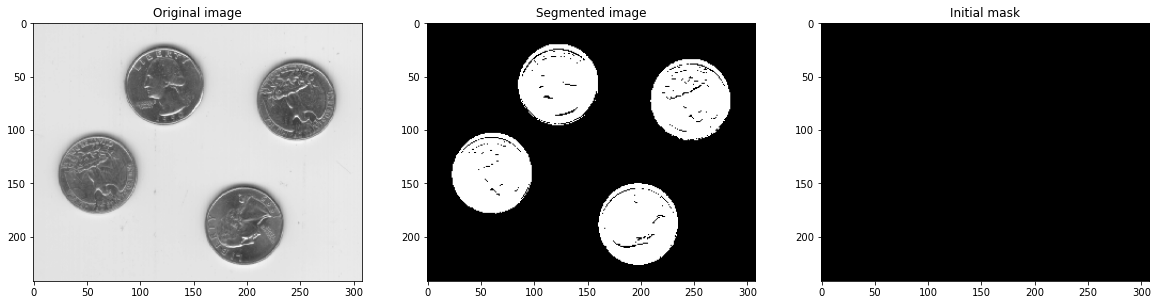

In [14]:
z0 = np.zeros_like(I)
mask = np.zeros_like(I)
unext, niter, energy = dual(I, mask,z0)
plot_results(I,unext,mask)

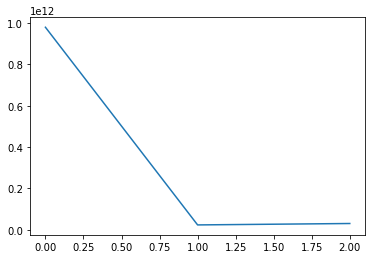

In [15]:
plt.plot(energy)


# Other examples

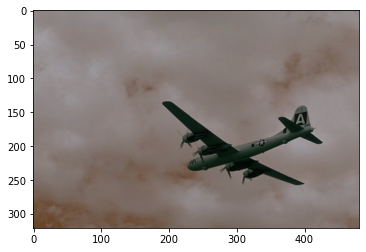

In [16]:
plane = cv.imread('plane.jpg')
plt.imshow(plane)
plt.show()

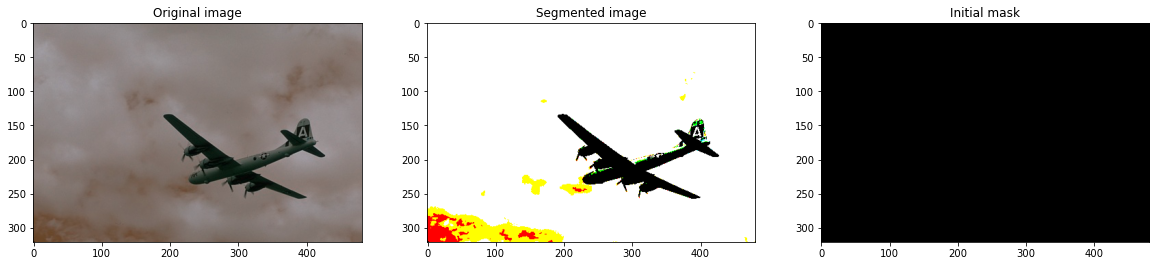

In [17]:
z0 = np.zeros_like(plane)
mask = np.zeros_like(plane)
unext, niter, energy = dual(plane, mask,z0)
plot_results(plane,unext,mask)

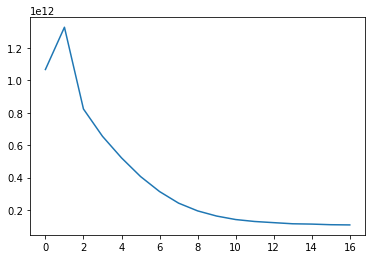

In [18]:
plt.plot(energy)

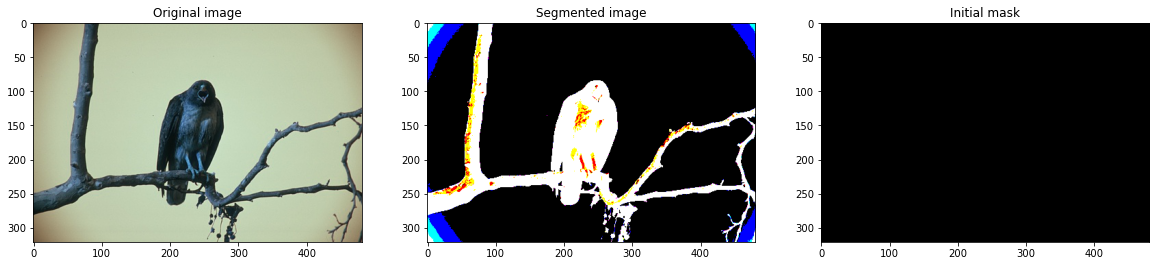

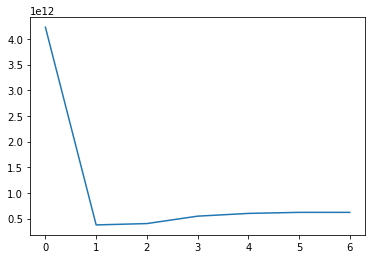

In [19]:
bird = cv.imread('bird.jpg')
z0 = np.zeros_like(bird)
mask = np.zeros_like(bird)
unext, niter, energy = dual(bird, mask,z0)
plot_results(bird,unext,mask)
plt.plot(energy)

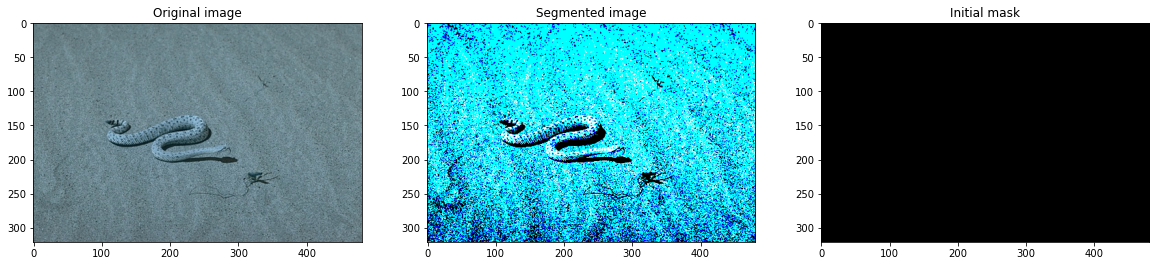

In [20]:
snake = cv.imread('snake.jpg')
z0 = np.zeros_like(snake)
mask = np.zeros_like(snake)
unext, niter, energy = dual(snake, mask,z0)
plot_results(snake,unext,mask)